### Selected Topic: (B) Text Emotion Recognition (TER)

Text emotion recognition (TER) involves predicting emotions expressed in text and documents. Existing
algorithms find emotion by learning the relationships of words using recurrent neural networks (RNN) or
convolutional neural networks (CNN). RNN and CNN capture local information (i.e., emotion of words)
and ignore the global information (i.e., emotion of sentence).

Interesting projects would be
1. To develop deep learning techniques for capture both local and global information. The local
information refers to emotions expressed by words and global information refers to emotions
expressed by the meanings of sentences.
2. To develop techniques that are invariant to speaker’s writing styles and characteristics 

References:
1. Kim, Y. Convolutional neural networks for sentence classification, Conference on Empirical
Methods in Natural Language Processing, pp. 1746–1751, 2014.
2. Lai, S., Xu, L., Liu, K., & Zhao, J. Recurrent convolutional neural networks for text classification.
Proceedings of the National Conference on Artificial Intelligence, vol. 3, pp. 2267–2273, 2015.
3. Zhou, P., Qi, Z., Zheng, S., Xu, J., Bao, H., & Xu, B. Text classification improved by integrating
bidirectional LSTM with two-dimensional max pooling. 26th International Conference on
Computational Linguistics, vol. 2, no.1, 3485–3495, 2016.
Datasets:
1. CROWDFLOWER: https://data.world/crowdflower/sentiment-analysis-in-text
2. WASSA2017: https://github.com/vinayakumarr/WASSA-2017/tree/master/wassa

# Imports

In [1]:
SEED = 42

import os

import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)

import pandas as pd

# Dataset Preparation & Preprocessing

* Dataset has already been preprocessed by combining WASSA2017 and CROWDFLOWER

In [2]:
# Read CSV
df = pd.read_csv('Feature-Engineered_datacombined.csv')

# Display the first few rows of the df
print(df.head())

   Unnamed: 0  index                                              tweet  \
0           0      0  @ZubairSabirPTI  pls dont insult the word 'Molna'   
1           1      1  @ArcticFantasy I would have almost took offens...   
2           2      2  @IllinoisLoyalty that Rutgers game was an abom...   
3           3      3  @CozanGaming that's what lisa asked before she...   
4           4      4  Sometimes I get mad over something so minuscul...   

  tweettype tweettype2  charCount  wordCount  sentenceCount  capCharCount  \
0     anger   negative         49          7              1             6   
1     anger   negative         81         14              1             4   
2     anger   negative        114         20              3             6   
3     anger   negative         90         16              2             3   
4     anger   negative        133         25              1             3   

   capWordCount  ...  \ count  ] count  ^ count  _ count  ` count  { count  \
0       

In [3]:
# Verify list of columns
column_list = df.columns.tolist()

print(column_list)

['Unnamed: 0', 'index', 'tweet', 'tweettype', 'tweettype2', 'charCount', 'wordCount', 'sentenceCount', 'capCharCount', 'capWordCount', 'quotedWordCount', 'stopwordCount', 'uniqueWordCount', 'hashCount', 'mentionCount', 'avgWordLen', 'modTweet', '! count', '" count', '# count', '$ count', '% count', '& count', "' count", '( count', ') count', '* count', '+ count', ', count', '- count', '. count', '/ count', ': count', '; count', '< count', '= count', '> count', '? count', '@ count', '[ count', '\\ count', '] count', '^ count', '_ count', '` count', '{ count', '| count', '} count', '~ count', 'lemmatizedText']


In [4]:
# Verify unique labels in 'tweettype'
tweettype_labels = df['tweettype'].unique()
# Verify unique labels in 'tweettype'
tweettype2_labels = df['tweettype2'].unique()

print("Unique labels in tweettype:", tweettype_labels)
print("Unique labels in tweettype2:", tweettype2_labels)

# Count of each unique label in 'tweettype'
tweettype_counts = df['tweettype'].value_counts()
# Count of each unique label in 'tweettype2'
tweettype2_counts = df['tweettype2'].value_counts()

print("\nCounts for each label in tweettype:\n", tweettype_counts)
print("\nCounts for each label in tweettype2:\n", tweettype2_counts)

Unique labels in tweettype: ['anger' 'fear' 'joy' 'sadness' 'neutral' 'enthusiasm' 'surprise' 'love'
 'relief']
Unique labels in tweettype2: ['negative' 'positive' nan]

Counts for each label in tweettype:
 sadness       14484
neutral        9644
joy            6111
love           3842
enthusiasm     2535
anger          2374
surprise       2187
relief         1526
fear           1257
Name: tweettype, dtype: int64

Counts for each label in tweettype2:
 negative    18115
positive    16201
Name: tweettype2, dtype: int64


In [5]:
# Count NaN for 'tweettype2'
nan_count = df["tweettype2"].isna().sum()
print(nan_count)

# Create a mask for rows where tweettype is 'neutral' and tweettype2 is NaN
mask = (df['tweettype'] == 'neutral') & (df['tweettype2'].isna())

# Use the mask to replace NaN values in tweettype2 with 'neutral'
df.loc[mask, 'tweettype2'] = 'neutral'

# This step is actually redundant because 'tweettype2' is not used later to train/test the RNN models

9644


In [6]:
# Verify unique labels in 'tweettype' again
tweettype_labels = df['tweettype'].unique()
# Verify unique labels in 'tweettype2' again
tweettype2_labels = df['tweettype2'].unique()

print("Unique labels in tweettype:", tweettype_labels)
print("Unique labels in tweettype2:", tweettype2_labels)

# Count of each unique label in 'tweettype'
tweettype_counts = df['tweettype'].value_counts()
# Count of each unique label in 'tweettype2'
tweettype2_counts = df['tweettype2'].value_counts()

print("\nCounts for each label in tweettype:\n", tweettype_counts)
print("\nCounts for each label in tweettype2:\n", tweettype2_counts)

Unique labels in tweettype: ['anger' 'fear' 'joy' 'sadness' 'neutral' 'enthusiasm' 'surprise' 'love'
 'relief']
Unique labels in tweettype2: ['negative' 'positive' 'neutral']

Counts for each label in tweettype:
 sadness       14484
neutral        9644
joy            6111
love           3842
enthusiasm     2535
anger          2374
surprise       2187
relief         1526
fear           1257
Name: tweettype, dtype: int64

Counts for each label in tweettype2:
 negative    18115
positive    16201
neutral      9644
Name: tweettype2, dtype: int64


# Models & Model Architecture

## Imports & Preparation

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, TabularDataset, BucketIterator
from sklearn.model_selection import train_test_split
import spacy
import matplotlib.pyplot as plt

# Import Error using torchtext: https://stackoverflow.com/questions/66549818/getting-importerror-when-using-torchtext
# Install older version of torchtext

In [8]:
# 1. Data Preparation - only using lemmatizedText for text, tweettype for label
df_used = df[['lemmatizedText', 'tweettype']]  
df_used.columns = ['text', 'label']

# Split data into train and test (validation) set
train_df, test_df = train_test_split(df_used, test_size=0.2, random_state=42)

# Save train and test sets to CSV
train_df.to_csv('new_train.csv', index=False)
test_df.to_csv('new_test.csv', index=False)

# 2. Data Preprocessing
# Load spaCy model (English) for preprocessing 
nlp = spacy.load('en_core_web_sm')

# tokenizer function: use spaCy to tokenize text and return list of tokenized words
def tokenizer(text):
    return [tok.text for tok in nlp.tokenizer(text)]
# filter_pred function: check if text length > 0
def filter_pred(example):
    return len(example.text) > 0 

# Field objects for TabularDataset
# TEXT: Tokenize text using tokenizer, convert text to lowercase, include lengths of sequences
TEXT = Field(sequential=True, tokenize=tokenizer, lower=True, include_lengths=True)
LABEL = Field(sequential=False, use_vocab=True) 

# https://dzlab.github.io/dltips/en/pytorch/torchtext-datasets/
# Load data into train, test sets
train, test = TabularDataset.splits(
    path='',
    train='new_train.csv',
    test='new_test.csv',
    format='csv',
    skip_header=True,
    fields=[("text", TEXT), ("label", LABEL)],
    filter_pred=lambda x: len(x.text) > 0           # manage text length < 0
)

# Build vocabulary
TEXT.build_vocab(train)
LABEL.build_vocab(train)

# Model Parameters
vocab_size = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = len(LABEL.vocab)
batch_size = 64

# BucketIterator - batching
# https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a
train_iter, test_iter = BucketIterator.splits(
    (train, test),
    batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device='cpu' # couldn't configure cuda/ gpu use in time
)

# Define padding index based on the padding token's index in the vocabulary
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

### I. RNN

Epoch: 01, Train Loss: 1.911, Train Acc: 0.330, Test Loss: 1.882, Test Acc: 0.353
Epoch: 02, Train Loss: 1.847, Train Acc: 0.352, Test Loss: 1.786, Test Acc: 0.379
Epoch: 03, Train Loss: 1.811, Train Acc: 0.365, Test Loss: 1.758, Test Acc: 0.392
Epoch: 04, Train Loss: 1.783, Train Acc: 0.377, Test Loss: 1.745, Test Acc: 0.400
Epoch: 05, Train Loss: 1.755, Train Acc: 0.387, Test Loss: 1.727, Test Acc: 0.396
Epoch: 06, Train Loss: 1.733, Train Acc: 0.396, Test Loss: 1.682, Test Acc: 0.412
Epoch: 07, Train Loss: 1.710, Train Acc: 0.405, Test Loss: 1.716, Test Acc: 0.401
Epoch: 08, Train Loss: 1.683, Train Acc: 0.414, Test Loss: 1.693, Test Acc: 0.411
Epoch: 09, Train Loss: 1.666, Train Acc: 0.420, Test Loss: 1.675, Test Acc: 0.423
Epoch: 10, Train Loss: 1.643, Train Acc: 0.427, Test Loss: 1.684, Test Acc: 0.399
Epoch: 11, Train Loss: 1.622, Train Acc: 0.432, Test Loss: 1.672, Test Acc: 0.415
Epoch: 12, Train Loss: 1.610, Train Acc: 0.444, Test Loss: 1.648, Test Acc: 0.427
Epoch: 13, Train

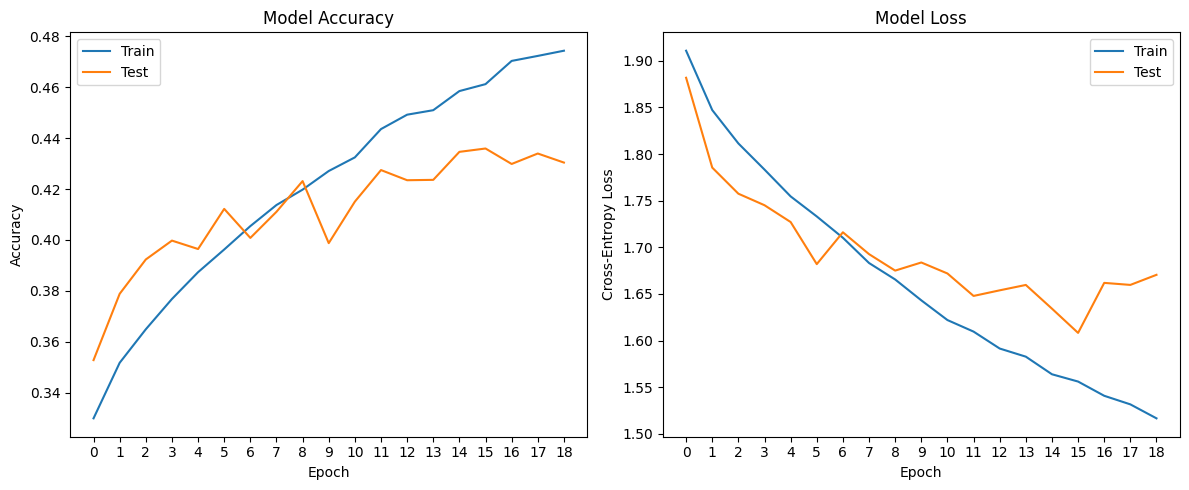

In [9]:
# 3. Model Class
class EmotionRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=3):
        super().__init__()

        # Embedding layer for word representations
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # Recurrent Layer (RNN)
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=False,  # Unidirectional RNN for now
            dropout=0.5 if num_layers > 1 else 0, 
            nonlinearity='tanh'
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, text, text_lengths):
        # Apply dropout to the input embeddings
        embedded = self.dropout(self.embedding(text))
        
        # Pack the embedded sequence for variable length sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False)
        
        # Forward pass through the RNN
        packed_output, hidden = self.rnn(packed_embedded)
        
        # Unpack the output sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        # Select the last hidden state from the RNN layers
        hidden = self.dropout(hidden[-1,:,:])
        
        # Pass the hidden state through a fully connected layer for classification
        return self.fc(hidden)

# Instantiate the model with unidirectional RNN
model = EmotionRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)

# 4. Training & Evaluation
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(y_pred, y):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

# Train function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch in iterator:
        text, text_lengths = batch.text
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = calculate_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = calculate_accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Early stopping criteria
patience = 3
patience_counter = 0
best_valid_loss = float('inf')

# Training loop with early stopping
N_EPOCHS = 100

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_iter, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}')

    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        torch.save(model.state_dict(), 'emotion_rnn_model_1.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Plot Model Accuracy and Model Loss during training
plt.figure(figsize=(12, 5))  # Adjust the figure size to make it rectangular

# Plot Accuracy
plt.subplot(1, 2, 1)  # Use 1 row, 2 columns, and the first subplot
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')  # Label x-axis as 'Epoch'
plt.ylabel('Accuracy')  # Label y-axis as 'Accuracy'

# Set custom x-axis ticks for the first subplot
plt.xticks(range(len(train_accuracies)))

# Plot Loss
plt.subplot(1, 2, 2)  # Use 1 row, 2 columns, and the second subplot
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')  # Label x-axis as 'Epoch'
plt.ylabel('Cross-Entropy Loss')  # Label y-axis as 'Cross-Entropy Loss'

# Set custom x-axis ticks for the second subplot
plt.xticks(range(len(train_losses)))

plt.tight_layout()  # Ensures that subplots don't overlap
plt.show()

In [10]:
# Load the best model
model.load_state_dict(torch.load('emotion_rnn_model_1.pth'))

# Calculate final training accuracy
_, train_acc = evaluate(model, train_iter, criterion)
# Calculate final test accuracy
_, test_acc = evaluate(model, test_iter, criterion)

print(f'Best Training Accuracy: {train_acc:.4f}')
print(f'Best Test Accuracy: {test_acc:.4f}')

Best Training Accuracy: 0.5181
Best Test Accuracy: 0.4359


### II. Bidirectional RNN

Epoch: 01, Train Loss: 1.905, Train Acc: 0.333, Test Loss: 1.792, Test Acc: 0.375
Epoch: 02, Train Loss: 1.847, Train Acc: 0.352, Test Loss: 1.789, Test Acc: 0.386
Epoch: 03, Train Loss: 1.816, Train Acc: 0.364, Test Loss: 1.773, Test Acc: 0.382
Epoch: 04, Train Loss: 1.794, Train Acc: 0.373, Test Loss: 1.752, Test Acc: 0.392
Epoch: 05, Train Loss: 1.763, Train Acc: 0.381, Test Loss: 1.716, Test Acc: 0.402
Epoch: 06, Train Loss: 1.743, Train Acc: 0.391, Test Loss: 1.708, Test Acc: 0.393
Epoch: 07, Train Loss: 1.717, Train Acc: 0.398, Test Loss: 1.698, Test Acc: 0.400
Epoch: 08, Train Loss: 1.697, Train Acc: 0.401, Test Loss: 1.677, Test Acc: 0.413
Epoch: 09, Train Loss: 1.674, Train Acc: 0.414, Test Loss: 1.693, Test Acc: 0.413
Epoch: 10, Train Loss: 1.654, Train Acc: 0.416, Test Loss: 1.682, Test Acc: 0.408
Epoch: 11, Train Loss: 1.635, Train Acc: 0.427, Test Loss: 1.652, Test Acc: 0.417
Epoch: 12, Train Loss: 1.617, Train Acc: 0.438, Test Loss: 1.645, Test Acc: 0.426
Epoch: 13, Train

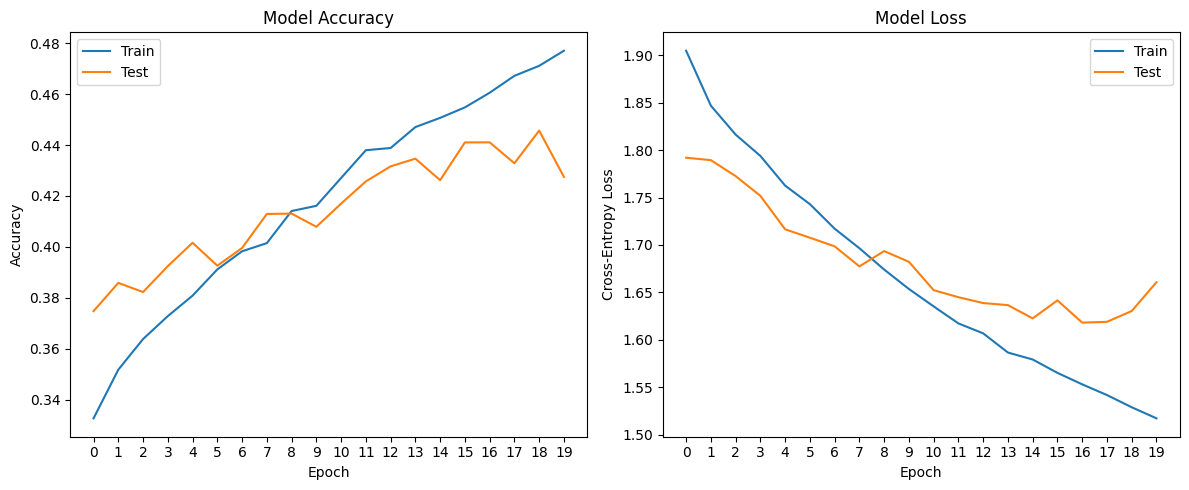

In [11]:
class EmotionBiRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=3, bidirectional=True):
        super().__init__()

        # Embedding layer for word representations
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # Recurrent layer
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,  # RNN is bidirectional
            dropout=0.5 if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)  # Multiply by 2 for bidirectional
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, text, text_lengths):
        # Embedding layer with dropout
        embedded = self.dropout(self.embedding(text))
        
        # Pack the embedded sequence for variable length sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False)
        
        # Forward pass through the RNN
        packed_output, hidden = self.rnn(packed_embedded)
        
        # Unpack the output sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        # If the RNN is bidirectional, concatenate the last hidden states of both directions
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        # Pass the concatenated hidden state through a fully connected layer for classification
        return self.fc(hidden)

# Create an instance of the EmotionBiRNN model
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]
model = EmotionBiRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)

# Training & Evaluation
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(y_pred, y):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

# Train function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch in iterator:
        text, text_lengths = batch.text
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = calculate_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluate function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = calculate_accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Early stopping criteria
patience = 3
patience_counter = 0
best_valid_loss = float('inf')

# Training loop with early stopping
N_EPOCHS = 100

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_iter, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}')

    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        torch.save(model.state_dict(), 'emotion_bi_rnn_model_1.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

plt.figure(figsize=(12, 5))  # Adjust the figure size to make it rectangular

# Plot Accuracy
plt.subplot(1, 2, 1)  # Use 1 row, 2 columns, and the first subplot
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')  # Label x-axis as 'Epoch'
plt.ylabel('Accuracy')  # Label y-axis as 'Accuracy'

# Set custom x-axis ticks for the first subplot
plt.xticks(range(len(train_accuracies)))

# Plot Loss
plt.subplot(1, 2, 2)  # Use 1 row, 2 columns, and the second subplot
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')  # Label x-axis as 'Epoch'
plt.ylabel('Cross-Entropy Loss')  # Label y-axis as 'Cross-Entropy Loss'

# Set custom x-axis ticks for the second subplot
plt.xticks(range(len(train_losses)))

plt.tight_layout()  # Ensures that subplots don't overlap
plt.show()

In [12]:
# Load the best model
model.load_state_dict(torch.load('emotion_bi_rnn_model_1.pth'))

# Calculate final training accuracy
_, train_acc = evaluate(model, train_iter, criterion)
# Calculate final test accuracy
_, test_acc = evaluate(model, test_iter, criterion)

print(f'Best Training Accuracy: {train_acc:.4f}')
print(f'Best Test Accuracy: {test_acc:.4f}')

Best Training Accuracy: 0.5195
Best Test Accuracy: 0.4411


#### III. CNN + RNN

Epoch: 01, Train Loss: 1.943, Train Acc: 0.305, Test Loss: 1.919, Test Acc: 0.243
Epoch: 02, Train Loss: 1.866, Train Acc: 0.339, Test Loss: 1.761, Test Acc: 0.371
Epoch: 03, Train Loss: 1.827, Train Acc: 0.361, Test Loss: 1.814, Test Acc: 0.387
Epoch: 04, Train Loss: 1.797, Train Acc: 0.375, Test Loss: 1.708, Test Acc: 0.402
Epoch: 05, Train Loss: 1.774, Train Acc: 0.383, Test Loss: 1.744, Test Acc: 0.398
Epoch: 06, Train Loss: 1.748, Train Acc: 0.397, Test Loss: 1.703, Test Acc: 0.412
Epoch: 07, Train Loss: 1.727, Train Acc: 0.407, Test Loss: 1.702, Test Acc: 0.404
Epoch: 08, Train Loss: 1.708, Train Acc: 0.409, Test Loss: 1.686, Test Acc: 0.406
Epoch: 09, Train Loss: 1.697, Train Acc: 0.411, Test Loss: 1.698, Test Acc: 0.420
Epoch: 10, Train Loss: 1.673, Train Acc: 0.421, Test Loss: 1.700, Test Acc: 0.408
Epoch: 11, Train Loss: 1.657, Train Acc: 0.425, Test Loss: 1.658, Test Acc: 0.413
Epoch: 12, Train Loss: 1.641, Train Acc: 0.429, Test Loss: 1.672, Test Acc: 0.414
Epoch: 13, Train

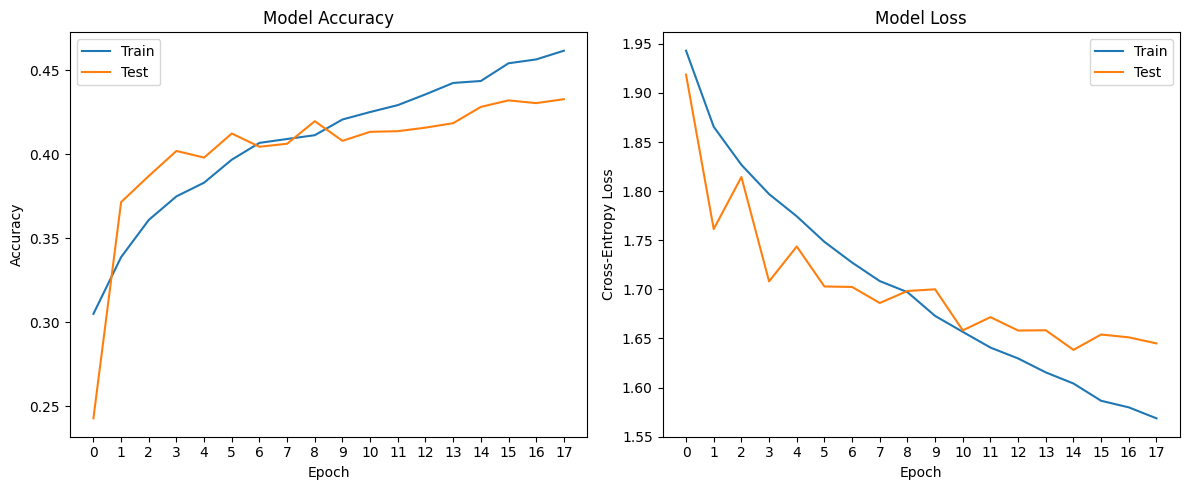

In [15]:
import torch.nn.functional as F

class EmotionCNNRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, num_layers=3, bidirectional=True, n_filters=100, filter_sizes=[3,4,5]):
        super().__init__()
        
        # Embedding layer for word representations
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, 
                      out_channels=n_filters, 
                      kernel_size=(fs, embedding_dim),
                      padding=(fs // 2, 0))
            for fs in filter_sizes
        ])

        # Recurrent layer
        self.rnn = nn.RNN(
            input_size=n_filters * len(filter_sizes),
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=0.5 if num_layers > 1 else 0,
            nonlinearity='tanh'
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, text, text_lengths):
        # Embedding layer
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)

        # Permute dimensions for convolutional layers
        embedded = embedded.permute(1, 0, 2)
        embedded = embedded.unsqueeze(1)

        # Convolutional layers with ReLU activation
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        # Max pooling over time
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Concatenate pooled features
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)

        # Reshape for RNN
        cat = cat.unsqueeze(0)

        # RNN layer
        output, hidden = self.rnn(cat)

        # Concatenate bidirectional RNN hidden states if bidirectional
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        hidden = self.dropout(hidden)

        # Fully connected layer for classification
        return self.fc(hidden)

# Create an instance of the EmotionCNNRNN model
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]
model = EmotionCNNRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)

# Training & Evaluation
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch in iterator:
        text, text_lengths = batch.text
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = calculate_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluate function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = calculate_accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Early stopping criteria
patience = 3
patience_counter = 0
best_valid_loss = float('inf')

# Training loop with early stopping
N_EPOCHS = 100

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_iter, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}')

    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        torch.save(model.state_dict(), 'emotion_cnn_bi_rnn_model_1.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

plt.figure(figsize=(12, 5))  # Adjust the figure size to make it rectangular

# Plot Accuracy
plt.subplot(1, 2, 1)  # Use 1 row, 2 columns, and the first subplot
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')  # Label x-axis as 'Epoch'
plt.ylabel('Accuracy')  # Label y-axis as 'Accuracy'

# Set custom x-axis ticks for the first subplot
plt.xticks(range(len(train_accuracies)))

# Plot Loss
plt.subplot(1, 2, 2)  # Use 1 row, 2 columns, and the second subplot
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')  # Label x-axis as 'Epoch'
plt.ylabel('Cross-Entropy Loss')  # Label y-axis as 'Cross-Entropy Loss'

# Set custom x-axis ticks for the second subplot
plt.xticks(range(len(train_losses)))

plt.tight_layout()  # Ensures that subplots don't overlap
plt.show()

In [16]:
# Load the best model
model.load_state_dict(torch.load('emotion_cnn_bi_rnn_model_1.pth'))

# Calculate final training accuracy
_, train_acc = evaluate(model, train_iter, criterion)
# Calculate final test accuracy
_, test_acc = evaluate(model, test_iter, criterion)

print(f'Best Training Accuracy: {train_acc:.4f}')
print(f'Best Test Accuracy: {test_acc:.4f}')

Best Training Accuracy: 0.5147
Best Test Accuracy: 0.4281
